In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline

### Загрузим данные

In [5]:
no_pres = pd.read_csv('no_present.csv')   # без презентации
yes_pres = pd.read_csv('yes_present.csv') # с презентацией
cust_data = pd.read_csv('cust_data.csv')  # инфа о клиентах
cust_data.tail()

,Client ID,Age,Gender,Monthly Income
495,99250,35,F,3361.19
496,99293,40,F,5103.11
497,99516,32,M,4882.56
498,99526,32,F,5561.87
499,99744,44,F,10153.13


### Сравним распределение по выручке
**HINT:** но перед этим, хочу обратить внимание, что я нашел случаи когда одному айдишнику соответствует несколько значений, и одному айдишнику соответствует несколько разных признаков. <br>
Поэтому я удалю эти некорректные данные.

In [6]:
# получаем хэш-мап id: count(id)
clid_no = [no_pres['Client ID'].value_counts()][0] 
clid_yes = [yes_pres['Client ID'].value_counts()][0]
clid_data = [cust_data['Client ID'].value_counts()][0]
clid_no[:3]

13472    2
54289    2
10422    1
Name: Client ID, dtype: int64

In [7]:
no_pres = no_pres.drop_duplicates(subset='Client ID', keep=False) #keep=False удаляет все дубликаты
# в таблице "с презентацией" дубликатов не было, а в таблице "информация о клиентах" были те же, ранее удаленные дубликаты
# поэтому при join-е удвоений возникнуть не должно
len(no_pres), len(yes_pres)

(263, 233)

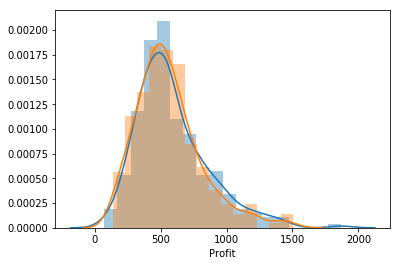

In [8]:
sns.distplot(no_pres.Profit)
sns.distplot(yes_pres.Profit)

В принципе, формы схожи и данные скорее всего из одного распределения (проверю позже). <br>
Но у нас ещё есть данные о клиентах, поэтому давайте сджойним по айдишникам и посмотрим на распределения по признакам клиентов.

In [9]:
cust_data['Gender'] = cust_data['Gender'].map({'M': 0, 'F': 1}) 

no_pres_full = pd.merge(no_pres, cust_data, how='left', on=['Client ID'])
yes_pres_full = pd.merge(yes_pres, cust_data, how='left', on=['Client ID'])
no_pres_full.dropna(inplace=True); yes_pres_full.dropna(inplace=True) # после джойна
print(len(no_pres_full), len(yes_pres_full))
yes_pres_full.tail()

263 233


,Client ID,Profit,Age,Gender,Monthly Income
228,97503,386.73,39,0,3913.31
229,97820,539.90,42,1,5383.15
230,97823,642.27,39,0,5255.26
231,98176,373.02,42,1,5042.72
232,99526,584.42,32,1,5561.87


Как видно, после джойна и dropna размерности не поменялись, а значит все данные хорошо проклеились.
### Посмотрим на распределение аттрибутов

In [27]:
### "пол" имеет распределение бернули, поэтому построим доверительный интервал для разности двух долей
def proportions_confint_diff_ind(sample1, sample2, alpha):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

Attr: Profit | U p-value: 0.20049028205207275 | Kr p-value: 0.4008045946453058 |
Attr: Age | U p-value: 0.2569164025782166 | Kr p-value: 0.513629966045503 |
Attr: Monthly Income | U p-value: 5.342260842014966e-15 | Kr p-value: 1.0658208928617267e-14 |
Attr: Gender
a=0.01: (-0.17730321121969814, 0.053933051784981395)
a=0.05: (-0.14965961024707514, 0.02628945081235838)
a=0.1: (-0.1355156331165912, 0.012145473681874464)


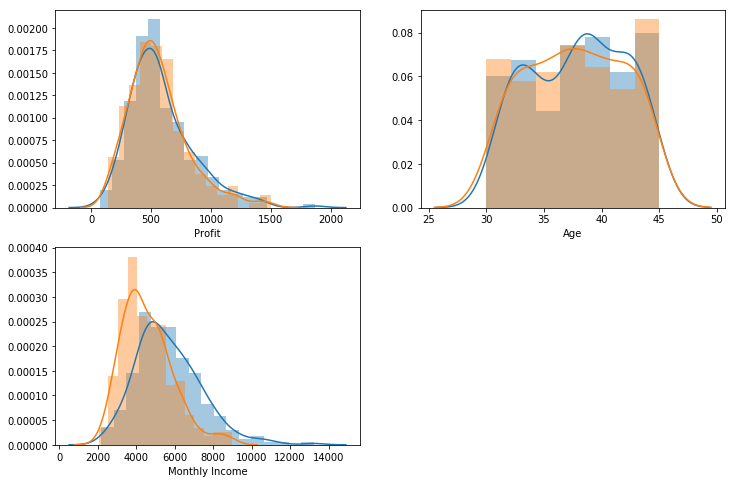

In [26]:
cols = ['Profit', 'Age', 'Monthly Income']
plt.figure(figsize=(12, 8))
for i,j in enumerate(cols):
    plt.subplot(2, 2, i+1)
    sns.distplot(no_pres_full[j])
    sns.distplot(yes_pres_full[j])
    u1, p1 = stats.mannwhitneyu(no_pres_full[j], yes_pres_full[j])
    u2, p2 = stats.kruskal(no_pres_full[j], yes_pres_full[j])
    print(f'Attr: {j} | U p-value: {p1} | Kr p-value: {p2} |')

print("Attr: Gender")
for a in [0.01, 0.05, 0.1]:
    print(f"a={a}: {proportions_confint_diff_ind(no_pres_full['Gender'], yes_pres_full['Gender'], a)}")

### Выводы
При любом уровне значимости (1%, 5%, 10%) по аттрибуту "Monthly Income" выборки взяты из разных распределений. <br>
Полученые p-value для аттрибутов "Profit", "Age", "Gender" свидетельствуют о принадлежности к одному распределению. <br>

**Вопросы к задаче:** <br>
>1. Почему средняя прибыль по клиентам с презентацией оказалась ниже, чем средняя прибыль по клиентам без презентации.<br>

**Скорее всего**, это связано с тем, что средний месячный доход выборки, которой **не показывали** презентацию, выше, чем средний месячный доход выборки, которой **показывали** презентацию. <br>
>2. Стоит ли продолжать практику проведения презентаций? <br>

Мы пока не подтвердили и не опровергли эту гипотезу. Нужно правильно поставить эксперимент. Выборки клиентов с- и без- презентаций должны
быть из одинаковых распределений, чтобы мы могли действительно сравнить их прогнозируемую годовую прибыль и заключить значимо они отличаются или нет.

In [269]:
print("Средний месячный доход выборки клиентов (без презентации): ",np.mean(no_pres_full['Monthly Income']),
      "\nСредний месячный доход выборки клиентов (с презентацией): ",np.mean(yes_pres_full['Monthly Income']))

Средний месячный доход выборки клиентов (без презентации):  5676.9836121673 
Средний месячный доход выборки клиентов (с презентацией):  4578.787081545064
